In [130]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, roc_auc_score, roc_curve
from sklearn.metrics import classification_report,precision_score, recall_score
from sklearn.decomposition import PCA

In [121]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier

Using TensorFlow backend.


In [2]:
df = pd.read_csv("data/weatherAUS.csv")
df.drop(columns=["RISK_MM"], axis = 1, inplace=True)

In [3]:
df.shape

(142193, 23)

In [4]:
df.isnull().sum()

Date                 0
Location             0
MinTemp            637
MaxTemp            322
Rainfall          1406
Evaporation      60843
Sunshine         67816
WindGustDir       9330
WindGustSpeed     9270
WindDir9am       10013
WindDir3pm        3778
WindSpeed9am      1348
WindSpeed3pm      2630
Humidity9am       1774
Humidity3pm       3610
Pressure9am      14014
Pressure3pm      13981
Cloud9am         53657
Cloud3pm         57094
Temp9am            904
Temp3pm           2726
RainToday         1406
RainTomorrow         0
dtype: int64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142193 entries, 0 to 142192
Data columns (total 23 columns):
Date             142193 non-null object
Location         142193 non-null object
MinTemp          141556 non-null float64
MaxTemp          141871 non-null float64
Rainfall         140787 non-null float64
Evaporation      81350 non-null float64
Sunshine         74377 non-null float64
WindGustDir      132863 non-null object
WindGustSpeed    132923 non-null float64
WindDir9am       132180 non-null object
WindDir3pm       138415 non-null object
WindSpeed9am     140845 non-null float64
WindSpeed3pm     139563 non-null float64
Humidity9am      140419 non-null float64
Humidity3pm      138583 non-null float64
Pressure9am      128179 non-null float64
Pressure3pm      128212 non-null float64
Cloud9am         88536 non-null float64
Cloud3pm         85099 non-null float64
Temp9am          141289 non-null float64
Temp3pm          139467 non-null float64
RainToday        140787 non-null obje

In [6]:
df["RainTomorrow"].value_counts()

No     110316
Yes     31877
Name: RainTomorrow, dtype: int64

# Data Preprocessing

### Removing Missing Values from numerical features

#### Removing null values from MinTemp, MaxTemp column by taking mean of the MinTemp, MaxTemp according to cities and fill at null values

In [7]:
numerical = df._get_numeric_data().columns
categorical = set(df.columns) - set(numerical)
loc_for_miss = df["Location"].unique().tolist()
ls = []
def removeNull(columns):
    j=0
    while j<=len(columns)-1:
        for i in range(len(loc_for_miss)):    
            ls.append(str(df.loc[df["Location"] == loc_for_miss[i], columns[j]].median())) #great outliers so used median

        for i in range(len(loc_for_miss)):
            df.loc[df["Location"] == loc_for_miss[i], columns[j]] = df.loc[df["Location"] == loc_for_miss[i], columns[j]].fillna(ls[i])
        j+=1
        df[columns] = df[columns].astype(float)
        
removeNull(numerical)

/Users/thesarang/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


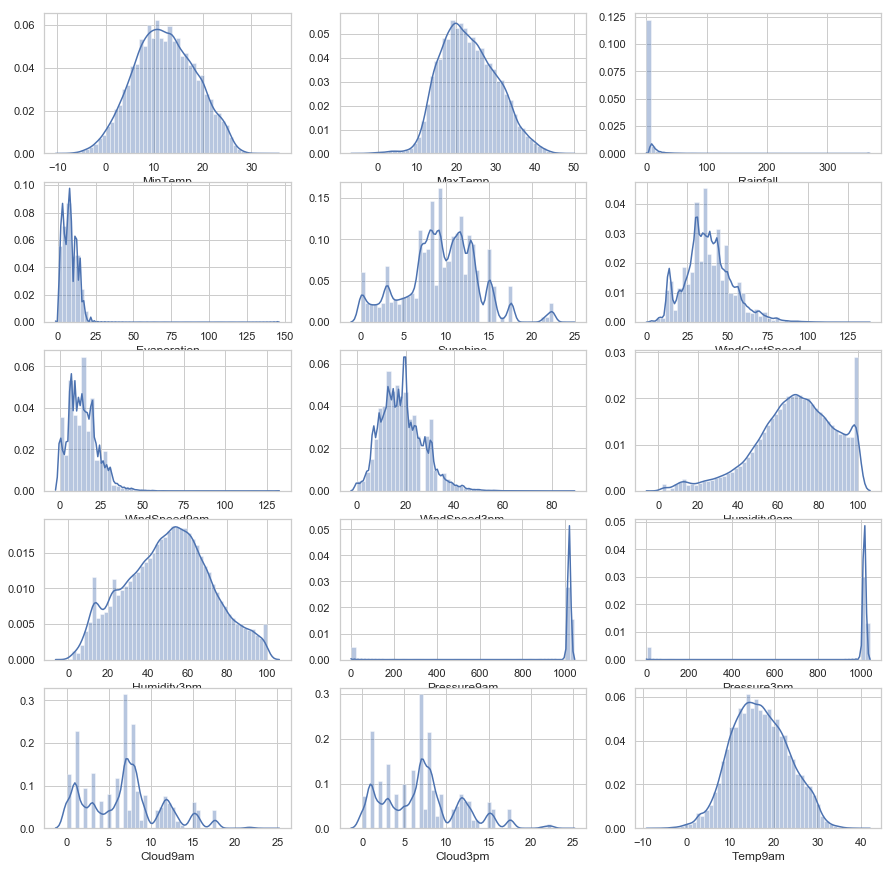

In [8]:
def plotHist():
    fig, ax =plt.subplots(5,3, figsize=(15,15))
    i=0;j=0;k=0
    while i<=4:
        while j<=2:
            sns.distplot(df[numerical[k]], ax=ax[i, j])
            j+=1;k+=1
        j=0;i+=1; 
    plt.savefig('distribution_before_removing_missing_values_from_numerical_columns.png')
    plt.show()
plotHist()

In [9]:
numerical

Index(['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
       'Temp9am', 'Temp3pm'],
      dtype='object')

In [10]:
categorical

{'Date',
 'Location',
 'RainToday',
 'RainTomorrow',
 'WindDir3pm',
 'WindDir9am',
 'WindGustDir'}

## Checking outliers in numerical columns

Index(['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
       'Temp9am', 'Temp3pm'],
      dtype='object')


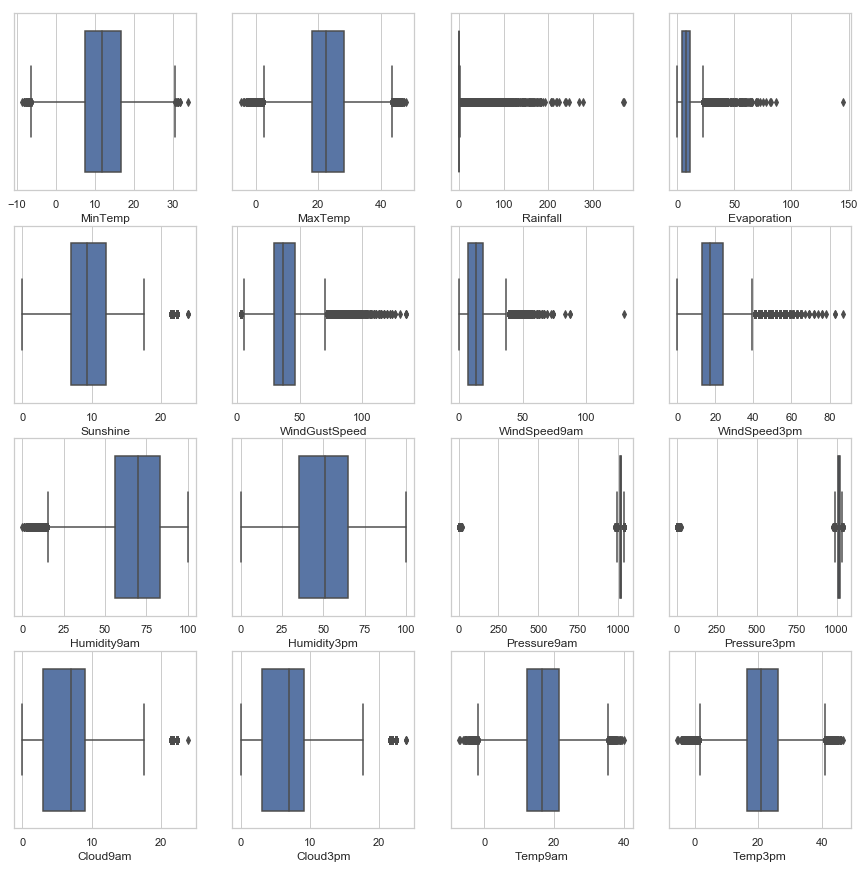

In [11]:
num_of_rows = 4
num_of_cols = 4
fig, ax = plt.subplots(num_of_rows, num_of_cols, figsize=(15,15))
print(numerical)
i=0;j=0;k=0;
while i<num_of_rows:
    while j<num_of_cols:
        sns.boxplot(df[numerical[k]], ax=ax[i, j])
        k+=1;j+=1
    j=0;i+=1
plt.savefig('before_removing_outliers_from_numerical_columns.png')
plt.show()

## Removing Outliers

In [12]:
lsUpper = []
lsLower = []
def removeOutliers(numerical):
    for i in range(len(numerical)):
        q1 = df[numerical[i]].quantile(0.25)
        q3 = df[numerical[i]].quantile(0.75)
        IQR = q3-q1
        minimum = q1 - 1.5 * IQR
        maximum = q3 + 1.5 * IQR
        df.loc[(df[numerical[i]] <= minimum), numerical[i]] = minimum
        df.loc[(df[numerical[i]] >= maximum), numerical[i]] = maximum  
removeOutliers(numerical)

Index(['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
       'Temp9am', 'Temp3pm'],
      dtype='object')


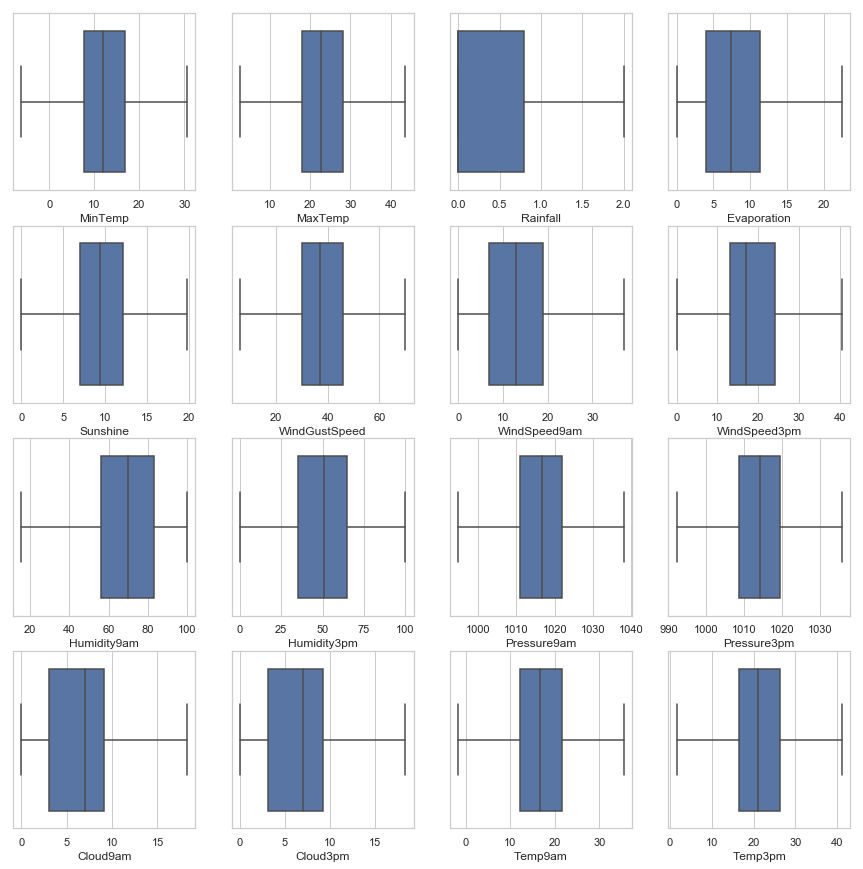

In [13]:
num_of_rows = 4
num_of_cols = 4
fig, ax = plt.subplots(num_of_rows, num_of_cols, figsize=(15,15))
print(numerical)
i=0;j=0;k=0;
while i<num_of_rows:
    while j<num_of_cols:
        sns.boxplot(df[numerical[k]], ax=ax[i, j])
        k+=1;j+=1
    j=0;i+=1
plt.savefig('after_removing_outliers_from_numerical_columns.png')
plt.show()

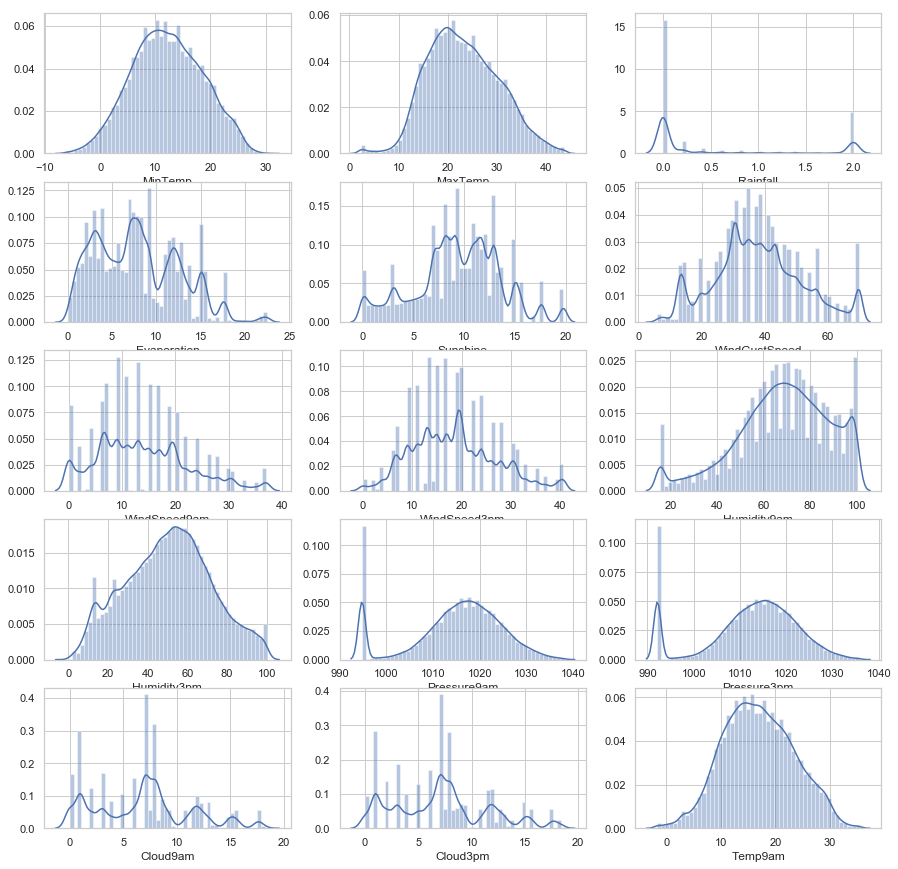

In [14]:
def plotHist():
    fig, ax =plt.subplots(5,3, figsize=(15,15))
    i=0;j=0;k=0
    while i<=4:
        while j<=2:
            sns.distplot(df[numerical[k]], ax=ax[i, j])
            j+=1;k+=1
        j=0;i+=1;
    plt.savefig('distribution_after_removing_outliers_from_numerical_columns.png')
    plt.show()
plotHist()

## Removing Missing Values from categorical data

### Check if all values of columns wrt every location are nan . If so replace them by geographically searching location near to given cities.  

### For special case of WindGustDir where some cities have mode as nan. So handling these cities saperately

In [15]:
# For WindGustDir column only
ls_WGD = []
loc_for_miss = df["Location"].unique()
for j in range(len(loc_for_miss)):
    df_allNanWGD = df.loc[df["Location"] == loc_for_miss[j]]
    if(df_allNanWGD["WindGustDir"].isnull().all()):
        ls_WGD.append(loc_for_miss[j])

In [16]:
#first handling these cities only
# 'Newcastle' is near to "Sydnay" with mode W,
# 'Albany' is near to "Perth" with mode SW

# Imputing W in Newcastle for WindGustDir column
df.loc[df["Location"] == "Newcastle", "WindGustDir"] = "W"
df.loc[df["Location"] == "Albany", "WindGustDir"] = "SW"

In [17]:
#mode in categorical varibles wrt cities
numerical = df._get_numeric_data().columns
# print("numerical features are", numerical)
# categorical = list(set(df.columns) - set(numerical))
categorical = ['RainToday', 'WindDir9am', 'WindDir3pm']
loc_for_miss = ['Albury','BadgerysCreek', 'Cobar', 'CoffsHarbour', 'Moree','Newcastle','NorahHead','NorfolkIsland',
                'Penrith','Richmond','Sydney','SydneyAirport','WaggaWagga','Williamtown','Wollongong','Canberra',
                'Tuggeranong','MountGinini','Ballarat','Bendigo','Sale','MelbourneAirport','Melbourne','Mildura',
                'Nhil','Portland','Watsonia','Dartmoor','Brisbane','Cairns','GoldCoast','Townsville','Adelaide',
                'MountGambier','Nuriootpa','Woomera','Albany','Witchcliffe','PearceRAAF','PerthAirport','Perth',
                'SalmonGums','Walpole','Hobart','Launceston','AliceSprings','Darwin','Katherine','Uluru']
ls = []
ls_allNAN = []
def removeNull(columns):
    for j in range(len(columns)):
        ls = []
        for i in range(len(loc_for_miss)): 
            ls.append(df.loc[df["Location"] == loc_for_miss[i], columns[j]].mode()[0])
        for i in range(len(loc_for_miss)):
            df.loc[df["Location"] == loc_for_miss[i], columns[j]] = df.loc[df["Location"] == loc_for_miss[i], columns[j]].fillna(ls[i])
        df[columns] = df[columns].astype(object)
    
removeNull(categorical)

['RainToday', 'WindDir9am', 'WindGustDir', 'WindDir3pm']


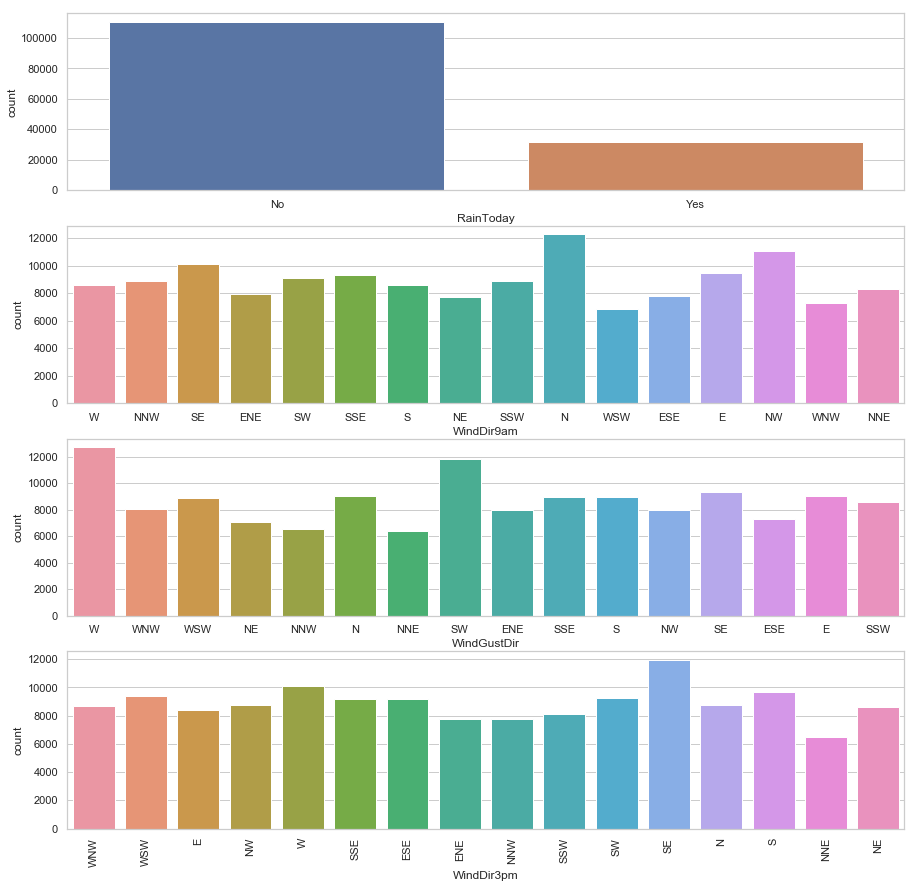

In [18]:
categoricalPlot = ['RainToday', 'WindDir9am','WindGustDir', 'WindDir3pm']
fig, ax = plt.subplots(4, 1, figsize=(15,15))
print(categoricalPlot)
c=0
while c<=3:
    sns.countplot(df[categoricalPlot[c]], ax=ax[c])
    plt.xticks(rotation=90)
    c+=1
plt.savefig('distribution_after_removing_missing_values_from_categorical_columns.png')
plt.show()

## Feature Engineering

In [19]:
#Adding extra columns by splitting date column
df['Year']=[d.split('-')[0] for d in df.Date]
df['Year'].astype(float)
df['Month']=[d.split('-')[1] for d in df.Date]
df['Day']=[d.split('-')[2] for d in df.Date]
df.drop(columns=["Date"], axis=1, inplace=True)

In [20]:
#performing labelEncoding on y i.e RainTommorrow
le = LabelEncoder()
df['RainTomorrow']= le.fit_transform(df['RainTomorrow'])
df.RainTomorrow.value_counts()

0    110316
1     31877
Name: RainTomorrow, dtype: int64

In [21]:
#Performing one hot encoding on RainToday, WindGustDir, WindDir9am, WindDir3pm, Location.
df_WindGustDir = pd.get_dummies(df["WindGustDir"], prefix="1")
df_WindDir9am = pd.get_dummies(df["WindDir9am"], prefix="2")
df_WindDir3pm = pd.get_dummies(df["WindDir3pm"], prefix="3")
df_RainToday = pd.get_dummies(df["RainToday"])
location_ohe = pd.get_dummies(df["Location"])
df_new = pd.concat([df, df_WindGustDir, df_WindDir9am, df_WindDir3pm, df_RainToday, location_ohe], axis=1)
df_new.drop(columns=["WindGustDir", "WindDir9am", "WindDir3pm", "RainToday", "Location"], axis=1, inplace=True)

In [22]:
#Taking average of columns annd create new column
df_new["AveTemp"] = (df_new["MinTemp"]+df_new["MaxTemp"])/2
df_new["WindSpeed12pm"] = (df_new["WindSpeed3pm"]+df_new["WindSpeed9am"])/2
df_new["Humidity12pm"] = (df_new["Humidity3pm"]+df_new["Humidity9am"])/2
df_new["Pressure12pm"] = (df_new["Pressure3pm"]+df_new["Pressure9am"])/2
df_new["Cloud12pm"] = (df_new["Cloud3pm"]+df_new["Cloud9am"])/2
df_new["Temp12am"] = (df_new["Temp3pm"]+df_new["Temp9am"])/2

### Splitting test and train data

In [23]:
X = df_new.loc[:,df_new.columns != "RainTomorrow"]
y = df_new.loc[:,["RainTomorrow"]]

In [24]:
y.RainTomorrow.value_counts()

0    110316
1     31877
Name: RainTomorrow, dtype: int64

In [25]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size=0.80, random_state=2, )
print(Xtrain.shape)
print(Xtest.shape)
print(ytrain.shape)
print(ytest.shape)

(113754, 124)
(28439, 124)
(113754, 1)
(28439, 1)


/Users/thesarang/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [26]:
# from imblearn.under_sampling import RandomUnderSampler
# from imblearn.over_sampling import RandomOverSampler
# rus = RandomOverSampler(random_state = 3)
# Xtrain, ytrain = rus.fit_sample(Xtrain, ytrain)

In [27]:
# from imblearn.over_sampling import SMOTE
# smote = SMOTE(ratio='minority')
# Xtrain, ytrain = smote.fit_sample(Xtrain, ytrain)
# Ensure columns are homogeneous - imblearn recasts as numpy array
# X_train_f_sm = pd.DataFrame(X_train_f_sm, columns=X_train_f.columns)

In [28]:
print(Xtrain.shape)
print(ytrain.shape)

(113754, 124)
(113754, 1)


### Performing standization

In [29]:
scaler = StandardScaler()
#fitting standardization on train data only
scaler.fit(Xtrain)
XtrainSTD = scaler.transform(Xtrain)
XtestSTD = scaler.transform(Xtest)

/Users/thesarang/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, float64, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/thesarang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype uint8, float64, object were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.
/Users/thesarang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype uint8, float64, object were all converted to float64 by StandardScaler.
  """


In [30]:
XtrainSTD.shape

(113754, 124)

## Performing PCA

In [108]:
pca = PCA(n_components=50)
pca.fit(XtrainSTD)
XtrainPCA = pca.transform(XtrainSTD)
XtestPCA = pca.transform(XtestSTD)
XtrainPCA.shape

(113754, 50)

In [109]:
pca.explained_variance_ratio_

array([0.06122614, 0.03677898, 0.03174079, 0.02943927, 0.02500555,
       0.01897984, 0.01676034, 0.01591849, 0.01534535, 0.01475175,
       0.01372195, 0.01335818, 0.01276189, 0.01204014, 0.01154284,
       0.0112101 , 0.01093213, 0.01088022, 0.01050458, 0.01003561,
       0.00988525, 0.00979285, 0.00967922, 0.00964107, 0.0094646 ,
       0.00926902, 0.00916377, 0.00910332, 0.00900638, 0.00893133,
       0.00881971, 0.00879972, 0.00873856, 0.00871348, 0.00859041,
       0.00855594, 0.00848348, 0.00842734, 0.0083561 , 0.00826719,
       0.0082504 , 0.00821285, 0.00818308, 0.00814669, 0.0081094 ,
       0.00808892, 0.00802171, 0.00801154, 0.00799769, 0.00795597])

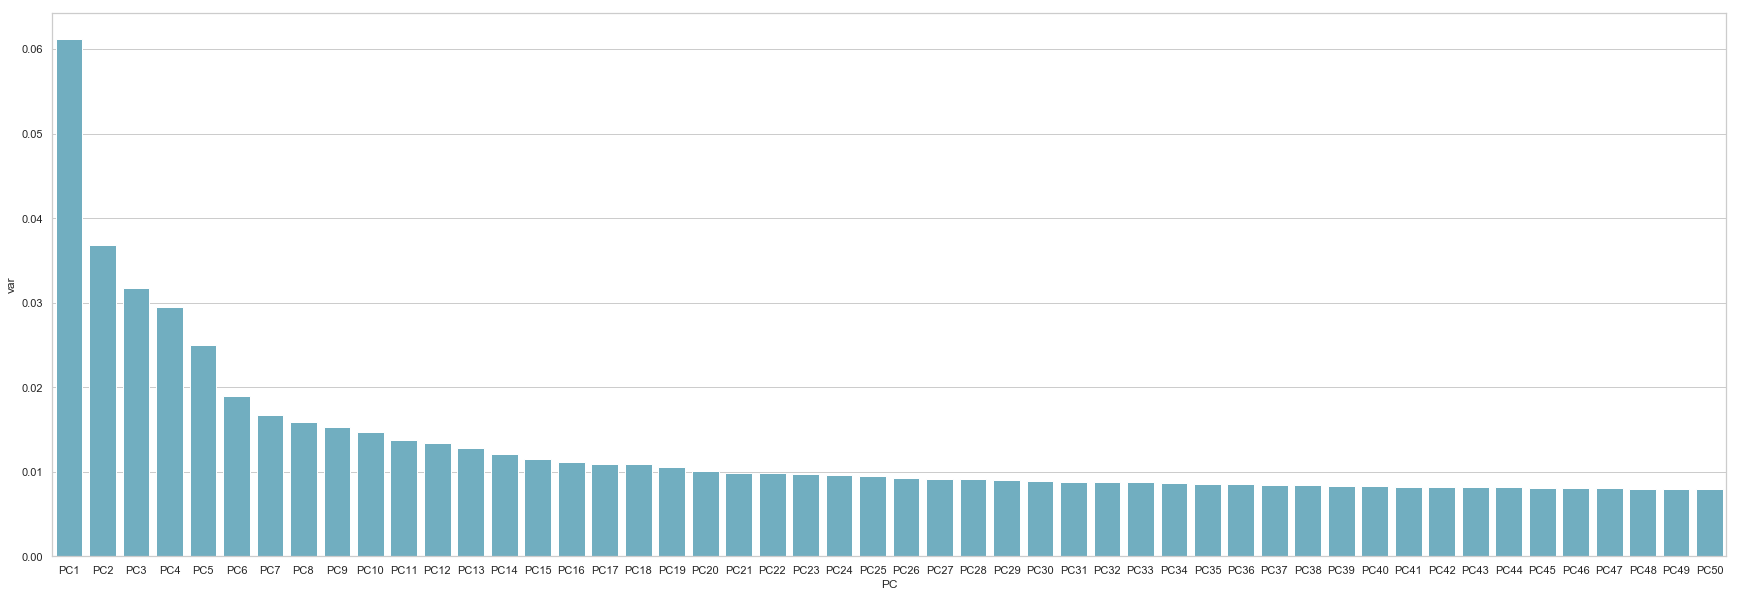

In [110]:
PC = ['PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8','PC9','PC10',
     'PC11','PC12','PC13','PC14','PC15','PC16','PC17','PC18','PC19','PC20',
     'PC21','PC22','PC23','PC24','PC25','PC26','PC27','PC28','PC29','PC30',
     'PC31','PC32','PC33','PC34','PC35','PC36','PC37','PC38','PC39','PC40',
     'PC41','PC42','PC43','PC44','PC45','PC46','PC47','PC48','PC49','PC50']
pca_df = pd.DataFrame({'var':pca.explained_variance_ratio_, 'PC':PC})
plt.figure(figsize=(30,10))
sns.barplot(x='PC',y="var", data=pca_df, color="c");

In [111]:
#Since very less variance in all columns, takingall columns into consideration

## Modeling

In [82]:
rf = RandomForestClassifier(random_state=0)
parameters = {'bootstrap': [True, False],
              'min_samples_split':[2, 3, 4],
              'criterion':['entropy', 'gini'],
              'n_estimators':[100, 200]
             }
grid_search1 = GridSearchCV(estimator=rf, param_grid=parameters, refit='roc_auc', scoring=['accuracy', 'roc_auc'], cv=10, n_jobs=-1)
grid_search1 = grid_search1.fit(XtrainSTD, ytrain.values.ravel())

In [91]:
print("Best Parameters : ",grid_search1.best_params_)
print("Best AUC-ROC : ", grid_search1.best_score_)

Best Parameters :  {'bootstrap': False, 'criterion': 'entropy', 'min_samples_split': 4, 'n_estimators': 200}
Best AUC-ROC :  0.8935522958088987


In [ ]:
#Building ranadom forest with these parameters

In [104]:
rf = RandomForestClassifier(bootstrap= False, criterion= 'entropy', min_samples_split= 4, n_estimators= 200, random_state=0)
rf.fit(XtrainSTD, ytrain.values.ravel())
ypred = rf.predict(XtestSTD)
accuracy = accuracy_score(ypred, ytest)
print(accuracy)

0.8567108548120539


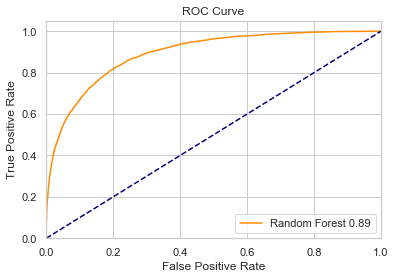

<Figure size 432x288 with 0 Axes>

In [106]:
def plot_curve(model, X_test, y_test,score, model_label):
    
    # function to plot roc curve for the given model
    y_score = pd.DataFrame(model.predict_proba(X_test))[1]
    fpr,tpr, threshold = roc_curve(y_test, y_score)
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', label='{} {}'.format(model_label,np.round(score,2)))
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()
    plt.savefig('roc random forest.png')
    
plot_curve(rf, XtestSTD, ytest, grid_search1.best_score_, "Random Forest")

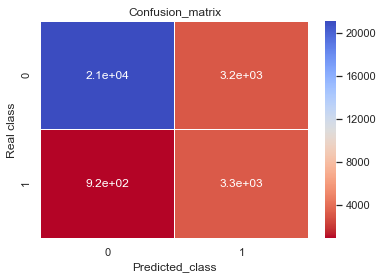

In [107]:
cnf_matrix = confusion_matrix(ypred, ytest)
sns.heatmap(cnf_matrix,cmap="coolwarm_r",annot=True,linewidths=0.5)
plt.title("Confusion_matrix")
plt.xlabel("Predicted_class")
plt.ylabel("Real class")
plt.show()

In [114]:
lr = LogisticRegression(random_state=0)
parameters = {'penalty': ['l1', 'l2'],
              'fit_intercept':[True, False]
             }
grid_search2 = GridSearchCV(estimator=lr, param_grid=parameters, refit='roc_auc', scoring=['accuracy', 'roc_auc'], cv=10, n_jobs=-1)
grid_search2 = grid_search2.fit(XtrainSTD, ytrain.values.ravel())

/Users/thesarang/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [115]:
print("Best Parameters : ",grid_search2.best_params_)
print("Best AUC-ROC : ", grid_search2.best_score_)

Best Parameters :  {'fit_intercept': True, 'penalty': 'l2'}
Best AUC-ROC :  0.8623464900429114


In [140]:
lr = LogisticRegression(fit_intercept=True, penalty='l2', random_state=0)
lr.fit(XtrainSTD, ytrain)
predict = lr.predict(XtestSTD)
accuracy = accuracy_score(predict, ytest)
roc_score = roc_auc_score(predict, ytest)
print(accuracy)

/Users/thesarang/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/thesarang/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.844579626569148


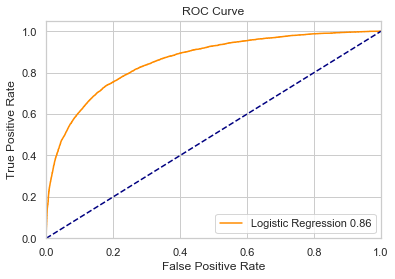

<Figure size 432x288 with 0 Axes>

In [141]:
def plot_curve(model, X_test, y_test,score, model_label):
    
    # function to plot roc curve for the given model
    y_score = pd.DataFrame(model.predict_proba(X_test))[1]
    fpr,tpr, threshold = roc_curve(y_test, y_score)
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', label='{} {}'.format(model_label,np.round(score,2)))
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()
    plt.savefig('roc2 logistic regression.png')
    
plot_curve(lr, XtestSTD, ytest, grid_search.best_score_, "Logistic Regression")

### Neural Network

In [132]:
from sklearn.model_selection import cross_val_score

In [154]:
classifier = Sequential()
classifier.add(Dense(units=62, init='uniform', activation='relu', input_dim=124))
classifier.add(Dense(units=62, init='uniform', activation='relu'))
classifier.add(Dense(units=1, init='uniform', activation='sigmoid'))
classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
classifier.fit(XtrainSTD, ytrain, batch_size=10, epochs=100)

/Users/thesarang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=62, activation="relu", input_dim=124, kernel_initializer="uniform")`
  
/Users/thesarang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=62, activation="relu", kernel_initializer="uniform")`
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/thesarang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1, activation="sigmoid", kernel_initializer="uniform")`
  after removing the cwd from sys.path.


Epoch 1/100
113754/113754 [==============================] - 10s 91us/step - loss: 0.3542 - acc: 0.8475
Epoch 2/100
113754/113754 [==============================] - 10s 89us/step - loss: 0.3332 - acc: 0.8566
Epoch 3/100
113754/113754 [==============================] - 10s 90us/step - loss: 0.3238 - acc: 0.8616
Epoch 4/100
113754/113754 [==============================] - 10s 91us/step - loss: 0.3175 - acc: 0.8641
Epoch 5/100
113754/113754 [==============================] - 10s 91us/step - loss: 0.3124 - acc: 0.8664
Epoch 6/100
113754/113754 [==============================] - 11s 93us/step - loss: 0.3085 - acc: 0.8679
Epoch 7/100
113754/113754 [==============================] - 10s 92us/step - loss: 0.3046 - acc: 0.8702
Epoch 8/100
113754/113754 [==============================] - 10s 89us/step - loss: 0.3012 - acc: 0.8713
Epoch 9/100
113754/113754 [==============================] - 10s 89us/step - loss: 0.2983 - acc: 0.8726
Epoch 10/100
113754/113754 [==============================] - 10

113754/113754 [==============================] - 10s 88us/step - loss: 0.2266 - acc: 0.9055
Epoch 79/100
113754/113754 [==============================] - 10s 88us/step - loss: 0.2263 - acc: 0.9053
Epoch 80/100
113754/113754 [==============================] - 10s 88us/step - loss: 0.2258 - acc: 0.9056
Epoch 81/100
113754/113754 [==============================] - 10s 88us/step - loss: 0.2258 - acc: 0.9052
Epoch 82/100
113754/113754 [==============================] - 10s 88us/step - loss: 0.2253 - acc: 0.9054
Epoch 83/100
113754/113754 [==============================] - 10s 88us/step - loss: 0.2246 - acc: 0.9061
Epoch 84/100
113754/113754 [==============================] - 10s 88us/step - loss: 0.2245 - acc: 0.9057
Epoch 85/100
113754/113754 [==============================] - 10s 88us/step - loss: 0.2245 - acc: 0.9066
Epoch 86/100
113754/113754 [==============================] - 10s 88us/step - loss: 0.2240 - acc: 0.9063
Epoch 87/100
113754/113754 [==============================] - 10s 89

In [156]:
ypred = classifier.predict(XtestSTD)
ypred = (ypred>0.5)
accuracy_NN = accuracy_score(ypred, ytest)
roc_NN = roc_auc_score(ypred, ytest)
accuracy_NN

0.840254579978199

In [160]:
roc_NN

0.7789927606628203

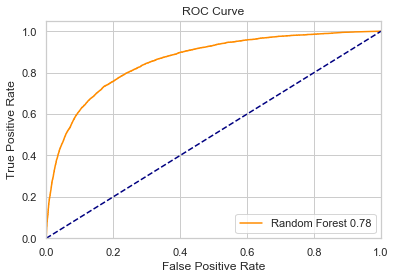

<Figure size 432x288 with 0 Axes>

In [162]:
def plot_curve(model, X_test, y_test,score, model_label):
    
    # function to plot roc curve for the given model
    y_score = pd.DataFrame(model.predict_proba(X_test))
    fpr,tpr, threshold = roc_curve(y_test, y_score)
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', label='{} {}'.format(model_label,np.round(score,2)))
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()
    plt.savefig('roc random forest.png')
    
plot_curve(classifier, XtestSTD, ytest, roc_NN, "Random Forest")